Welcome to the third installment of AI Nuggets! If you're anything like me, the topic we are covering today has haunted your dreams. Imagine the following scenario... You have a final exam in your intro to AI class next week, and it's time to buckle down and study. For the next seven days, you hole yourself up in Leavey Library, chugging Chai tea lattes and shunning all sunlight. On day seven, the cake is baked, and its time to take your exam. A few days after the exam is over, your professor posts your grade as well as a histogram of your classmates' scores. Palms sweating, hands shaking, you work up the nerve to timidly click open the final exam score distribution. To your horror, you find just what you feared. It follows you like your shadow... the *NORMAL DISTRIBUTION*


When I first set out to write this post, I assumed that many natural phenomena were distributed via a Gaussian distribution. It was one of those strange things like pi or e or the Fibonnacci numbers... seemingly cropping up everywhere. I wanted to write about this.

However, as I started researching, I became skeptical. Undeniably I have seen many *unimodal* datasets in my life, datasets that have only one peak. But how did I know that these datasets were truly distributed *normally?* After all, the normal distribution is a very specific shape, not just any old lump in the data. 

In this notebook, we will dive into the normal distribution, examining its shape and fundamental properties. We will explore how these properties might make the Gaussian distribution a useful model for real world data. Finally, we will analyze possible shortcomings Gaussian-based ML models of might face in practice.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

First, lets take a look at two Gaussian or normal distributions to refresh your memory. The probability density function (PDF) of the normal distribution takes the form $\frac{1}{(\sigma\sqrt{2\pi})}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$
where $\sigma$ is the standard deviation (the square root of the variance) and $\mu$ is the mean. Below, we use numpy to create two different Gaussian distributions with different means and standard deviations. We sample from each 1000 times and plot a histogram of our samples below, alongside the PDF of each distribution.

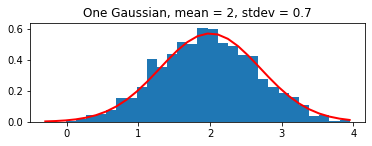

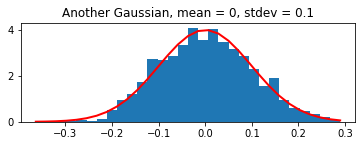

In [59]:
mu, sigma = 2, 0.7 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

mu1, sigma1 = 0, 0.1
s1 = np.random.normal(mu1, sigma1, 1000)

fig = plt.figure()
plt.subplot(211)
plt.title("One Gaussian, mean = 2, stdev = 0.7")
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()


plt.subplot(212)
plt.title("Another Gaussian, mean = 0, stdev = 0.1")
count, bins, ignored = plt.hist(s1, 30, density=True)
plt.plot(bins, 1/(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu1)**2 / (2 * sigma1**2) ),linewidth=2, color='r')
plt.show()

A key property of the normal distibution is that if we define a new random variable Z that represents the *sum* of two normally distributed random variables X1 and X2, the new variable Z is *also* distributed according to a normal distribution. Below, we do just this, and create a variable z that is equal to the samples from the two normal distributions above added together element-wise. 

It is simple to calculate the mean and standard deviation of z's Gaussian distribution! The Gaussian pdf satisfies the "convolution identity": $X_1 \sim \mathcal{N}(\mu_1,\,\sigma_1^{2}) + X_2 \sim \mathcal{N}(\mu_2,\,\sigma_2^{2}) \implies 
Z \sim \mathcal{N}(\mu_1 + \mu_2,\,\sigma_1^{2}+\sigma_2^{2})$

When adding two normal distributions, the resultant distribution is normal. The new mean is the sum of the two old means. The new variance is the sum of the two old variances. 

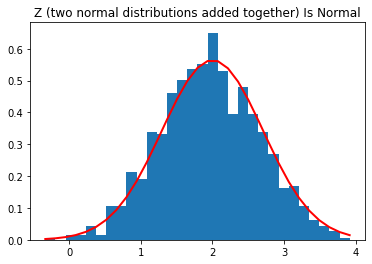

In [61]:
z = np.add(s, s1)
mu_sum = mu + mu1
sigma_sum = np.sqrt(sigma**2 + sigma1**2)

count, bins, ignored = plt.hist(z, 30, density=True)
plt.plot(bins, 1/(sigma_sum * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu_sum)**2 / (2 * sigma_sum**2) ),linewidth=2, color='r')
plt.title("Z (two normal distributions added together) Is Normal")
plt.show()

A similar property holds when we scale a normal distribution by multiplying it by some constant.  $X \sim \mathcal{N}(\mu,\,\sigma^{2}) \implies Z \sim \mathcal{N}(c\mu, c^{2}\sigma^{2}) $

This is demonstrated below, where we scale data drawn from a Gaussian distribution and find that the scaled data appears to fit a Gaussian with mean and variance shown above. 

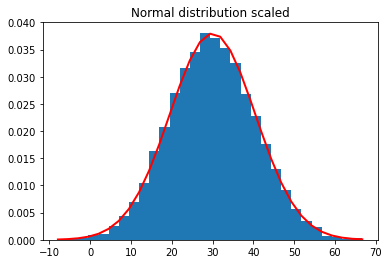

In [0]:
scalar = 15
mu, sigma = 2, 0.7 # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)*scalar
mu_scaled = mu*scalar
sigma_scaled = sigma*scalar

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma_scaled * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu_scaled)**2 / (2 * sigma_scaled**2) ),linewidth=2, color='r')
plt.title("Normal distribution scaled")
plt.show()

Consider how these properties might make the Gaussian distribution persistent in nature. For example, take the natural phenomenon of test scores. We can imagine that a test score is a random variable that is really the sum of many other contributing random variables, like hours of study, hours of sleep, number of prerequisites taken, etc. If these contributing factors are distributed normally and are all added together to generate a test score, then the test score will also be normally distributed! (Further, if test scores are a higher order polynomial function of other normal random variables, consider how the first order Taylor approximation of this function would conserve the normal distribution of test scores.) 

The convolution property of Gaussians explains how, once generated, this distribution might have a tendency to stick around. But we still haven't seen how Gaussian distributions might arise in the first place.

Enter the Central Limit Theorem! If you've taken a course on probability theory, you've heard of the CLT, which states that when independent probability distributions with defined variance are summed, their sums approach a Gaussian distribution as the number of samples approaches infinity. There are various versions of the CLT with various levels of generality. The important point here is that sample means of non-Gaussian random variables can be distributed via a Gaussian distribution.

To demonstrate this, consider the geometric random variable shown below, with parameter p. We will generate 100 samples from this distribution and plot it below. 

Sample mean =  2.97


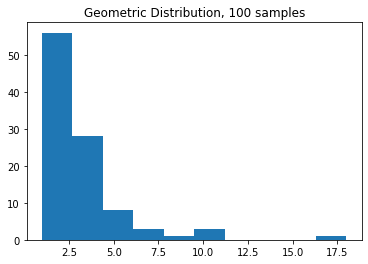

In [0]:
sampleSize = 100
p=0.35
sample = np.random.geometric(p=0.35, size=sampleSize)
print("Sample mean = ",np.mean(sample))
plt.hist(sample)
plt.title("Geometric Distribution, 100 samples")
plt.show()

Compare the distribution of the samples above to the Gaussian distribution. The mean of the sample is shown above the plot, and is likely around 2.8. We calculate the sample mean by just taking the average of all 100 samples we generated from the geometric distributions.

Now, we will generate many more sets of 100 samples from the geometric distribution, and will record each sample set's mean. We plot these **sample means from the geometric distribution** below.

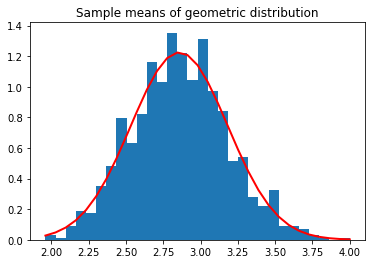

In [0]:
sampleMeans = ()
for i in range(1000):
  sample = np.random.geometric(p=0.35, size=sampleSize)
  sampleMeans = np.append(sampleMeans, np.mean(sample))

mu = 1/p
variance = ((1-p)/p**2)/sampleSize
sigma = math.sqrt(variance)

count, bins, ignored = plt.hist(sampleMeans, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.title("Sample means of geometric distribution")
plt.show()

Notice anything about the distribution of sample means? The sample means appear to be normally distibuted! The red curve above is the PDF of a Gaussian distribution with mean equal to the geometric distribution's mean, and variance equal to the geometric distribution's variance divided by the sample size (100). 

Below, I repeat the demonstration with a beta distribution. 

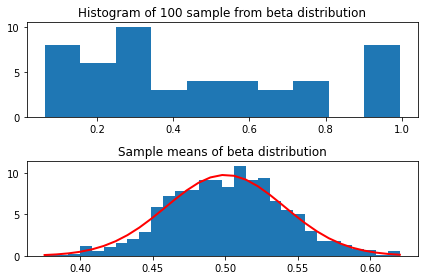

In [0]:
sampleSize = 50
a_ = 1
b_ = 1
sample = np.random.beta(a = a_, b = b_, size=sampleSize)
plt.subplot(211)
plt.title("Histogram of 100 sample from beta distribution")
plt.hist(sample)

sampleMeans = ()
for i in range(1000):
  sample = np.random.beta(a = a_, b = b_, size=sampleSize)
  sampleMeans = np.append(sampleMeans, np.mean(sample))

mu = a_/(a_+b_)
variance = (a_*b_)/(((a_+b_)**2)*(a_+b_+1))/sampleSize
sigma = math.sqrt(variance)

plt.subplot(212)
count, bins, ignored = plt.hist(sampleMeans, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.title("Sample means of beta distribution")
plt.tight_layout()
plt.show()

If you're anything like me, this result is very counterintuitive. I've been searching for an intuitive way to explain why the Central Limit Theorem is true, but unfortunately such an explanation is difficult to find. Nevertheless, are able to glean some intuitive insights from how the CLT is proven. The proof of the CLT makes use of the characteristic function of random variables. Just like the PDF, the characteristic function defines a random variable's distribution. In fact, the characteristic function is the Fourier transform of the PDF.

The characteristic function is useful when we add random variables together. If X and Y are independent random variables with PDF's $f_X(x)$ and $f_Y(y)$, then if we define Z to be the random variable X + Y, Z will have PDF:
$f_Z(z) = \int_{-\infty}^{\infty}f_Y(z-x)f_X(x) = f_X \ast f_Y$ 

This operation is defined as *convolution*. The convolution theorem states that the Fourier transform of the convolution of two PDF's is equal to the product of the Fourier transform of each PDF. Thus, we use the characteristic function of a random variable to relate convolution to multiplication, which in turn allows us to understand what happens when we add samples from random variables together. For those who want to dig further into a proof of the CLT, I recommend checking this one out: http://www.cs.toronto.edu/~yuvalf/CLT.pdf

If much of the data we observe in nature is the aggregate of many hidden, unknown variables that are somewhat independent, the Central Limit Theorem suggests that this data will be distributed approximately normally, especially as our sample sizes increase. 

There is another, related motivation for the Gaussian distribution that comes from information theory. The Gaussian distribution is the distribution with **maximum entropy** subject to a specified mean and varaince. If all we can reliably estimate from the data we have is mean and variance, a Gaussian distribution captures these properties with mimimum additional assumptions about how the data is distributed. Many common probability distributions are maximum entropy distributions, but the Gaussian is the maximum entropy distribution for the common scenario when we only know mean and variance. 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2824446/#R46
Murphy Probabalsitic ML

However, there are some instances where the Gaussian distribution fails to model data well. Take for example, bimodally distributed data. Below, we generate a dataset using two different normal distributions. Then, we fit a SINGLE normal distribution using the mean and variance of the whole dataset. 

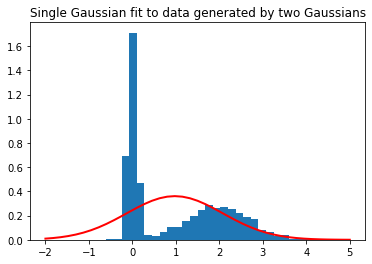

In [10]:
mu, sigma = 2, 0.7 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

mu1, sigma1 = 0, 0.1
s1 = np.random.normal(mu1, sigma1, 1000)

bimodal = np.append(s, s1)
mu_bimodal = np.mean(bimodal)
sigma_bimodal = np.std(bimodal)

fig = plt.figure()
count, bins, ignored = plt.hist(bimodal, 40, density=True, range = [-2,5])
plt.plot(bins, 1/(sigma_bimodal * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu_bimodal)**2 / (2 * sigma_bimodal**2) ),linewidth=2, color='r')
plt.title("Single Gaussian fit to data generated by two Gaussians")
plt.show()




How meaningful is the red bell curve above in understanting this bimodal data? Clearly not very. If we saw this dataset in the wild, we might try to fit a Gaussian Mixture Model to it, which could represent the two different peaks in the data with two different Gaussian distributions. We might see a pattern like this if our dataset contained SAT subject scores for both math and reading comprehension, where perhaps the mean and variances for the different subjects would be different. 

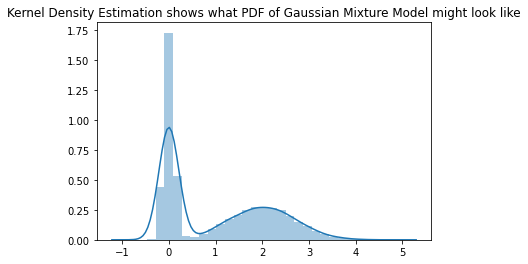

In [13]:
import seaborn as sns
n = 10000 
mu = [2, 0]
sigma = [0.7, 0.1]
samples = []
for i in range(n): # iteratively draw samples
    Z = np.random.choice([0,1]) # latent variable
    samples.append(np.random.normal(mu[Z], sigma[Z], 1))
sns.distplot(samples)
plt.title("Kernel Density Estimation shows what PDF of Gaussian Mixture Model might look like")
plt.show()

Even if you spot and account for bimodality in your data, another, perhaps more sinister trap remains. A unimodal distribution may still exhibit skewness and kurtosis. Skew means that a distribution is asymetrical about its mean. Kurtosis means that a distribution has heavy or light **tails**. A Gaussian distribution has kurtosis equal to 3, and other unimodal distributions can be compared to this benchmark. Skewness and kurtosis are the third and fourth **moments** of a distribtuion, just as mean and variance are the first and second moments. 

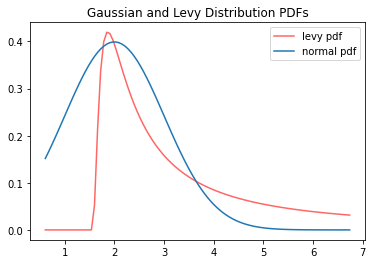

In [58]:
 from scipy.stats import levy
 from scipy.stats import norm

fig, ax = plt.subplots(1, 1)
x = np.linspace(levy.ppf(0.2),levy.ppf(0.7), 100)
ax.plot(x, levy.pdf(x, 1.5, 1.1), 'r-', alpha=0.6, label='levy pdf')
ax.plot(x, norm.pdf(x,2,1), label = 'normal pdf')
ax.legend()
plt.title("Gaussian and Levy Distribution PDFs")
plt.show()

Qualitatively, you can see above that the Levy distribution's PDF decays more slowly than the Gaussian distibution's PDF as you move away from the peak. If you modeled data from a Levy distribution using a Gaussian, you would tend to *underestimate* the probability of extreme values or outliers. 

This can be very consequential in practice, especially since the Generalized Central Limit theorem states that the Levy distribution attracts sample means/sums of distributions with "diverging variance." (Remember, the CLT only holds for sample sums/means of distribution with defined mean and variance.) Thus, we might expect to find fat tailed distributions in nature when a phenomenon is the sum of many random factors with undefined variance. And we do see fat tailed distributions quite often, often in finance and physics! https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0145604

In practice, *normality tests* can be very useful to determine if the data on your hands seems to be distributed via a Gaussian distibution. Some tests are visual, like looking at a histogram or analyzing a QQ plot. Others are more quantitative, like the Shapiro-Wilk test, D’Agostino test, and Anderson–Darling test that are all conveniently implemented already in SciPy.stats

However, knowing how to test for normality is useless if you don't know that you are assuming data is normally distributed in the first place! The normal distribution is so ubiquitous in ML and statistics that you may not be aware that some of your favorite algorithms rely on the assumption of normality. For example, linear regression (using least squares) assumes that residuals are distributed normally! The linear regression model has the form:

$p(y \mid x,\theta) = \mathcal{N}(w^Tx,\sigma^2)$

$w^Tx$ gives us the *mean* of a Gaussian distribution. We expect that y will fall somewhere close to this mean. Plugging in the PDF of the Gaussian distribution in the equation above, we find that for a single datapoint i:

$p(y_i \mid x_i,\theta) = \frac{1}{(\sigma\sqrt{2\pi})}e^{-\frac{1}{2}(\frac{x_i-\mu}{\sigma})^2}$

Recall that we define the mean $\mu$ to be $w^Tx$:

$p(y_i \mid x_i,\theta) = \frac{1}{(\sigma\sqrt{2\pi})}e^{-\frac{1}{2}(\frac{x_i-w^Tx}{\sigma})^2}$

If we take the lof of this probability, we get the log likelihood of the datapoint $x_i,y_i$. The log likelihood of the parameters $\theta$ is just the sum of the likelihoods of all the N datapoints given $\theta$.

$l(\theta)=\sum_{i=1}^{N}log[ \frac{1}{(\sigma\sqrt{2\pi})}e^{-\frac{1}{2}(\frac{x_i-w^Tx}{\sigma})^2}]$

$l(\theta)=\frac{-1}{2\sigma^2}RSS(w) - \frac{N}{2}log(2\pi\sigma^2)$

Assuming Gaussian residuals, the only term in the likelihood that depends on w is the residual sum of squares. Our line of best fit corresponds to the weight vector w that y is distributed via a Gaussian distribution with a mean of $w^Tx$

In the wild, we sometimes encounter distributions with fatter tails and more outliers than the Gaussian distribution. Linear regression can be made more robust to outliers by using a fatter tailed distribution to model the residual distibution of y around $w^Tx$. For example, the Laplace distribution is used in a modification of linear regression called *robust regression*. In robust regression, we maximize the likelihood of the Laplace instead of the Gaussian for the residuals. 

In conclusion, the Central Limit Theorem suggests that data may often be normally distributed, especially if the phenomenon we are measuring results from the aggregate of many independent processes with defined mean and variances. However, the Generalized Central Limit theorem suggest similar attractive distributions like the Levy distribution arise when the independent processes being aggregated have undefined variance. These distributions are similar in that they are unimodal, but unimodal is not equiavalent to normal, and the normal distribution may underestimate the probabilities of outliers. If we incorporate normality assumptions into our machine learning models, then our models may not be as robust to outliers as if we instead assumed distributions with fatter tails. There are many techniques to assess normality and modaility that exist, but they are useless to us if we are unaware of the assumptions we make when we choose a given machine learning algorithm 

I'll leave you with a quote from statistician George Box... "All models are wrong, but some are useful"

I hope that this article has given you some more insight into the Gaussian distribution, and its implications as one of the most common assumptions in machine learning and statistics. It is crucial that we are cogniscient of the assumnptions we make in machine learning and in day to day life. Awareness of assumptions allows us to make more informed decisions about model selection, and empowers us to inform machine learning algorithms with prior knowledge we actually believe in. 